# HW Instructions
Wherever you see `# CODE HERE`, you have to complete the code yourself based on the steps of the ML pipeline and provided instructions. We recommend that you look at the in-class project notebook as a reference if you're struggling.

# Imports

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset # Added TensorDataset
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms
import numpy as np

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from torchsummary import summary

#Data Loading

##Malaria Cell Images Dataset
###Dataset Description
>This dataset consists of cell images for malaria detection, containing a total of 27,558 images divided into two categories:

>`Infected`: Cell images showing malaria parasites
>`Uninfected`: Normal cell images without malaria infection

##Source
> The dataset originates from the National Institutes of Health (NIH) and was made available through their official website (https://ceb.nlm.nih.gov/repositories/malaria-datasets/). It has been uploaded to facilitate easier and faster access, as downloading directly from the NIH website can be time-consuming.
#Application
>This dataset is intended for developing and testing machine learning models that can automatically detect malaria parasites in cell images, potentially assisting in faster and more accurate diagnosis of malaria infections.
Acknowledgment
Original source: National Institutes of Health (NIH)
Cover photo credit: Егор Камелев on Unsplash (https://unsplash.com/@ekamelev)

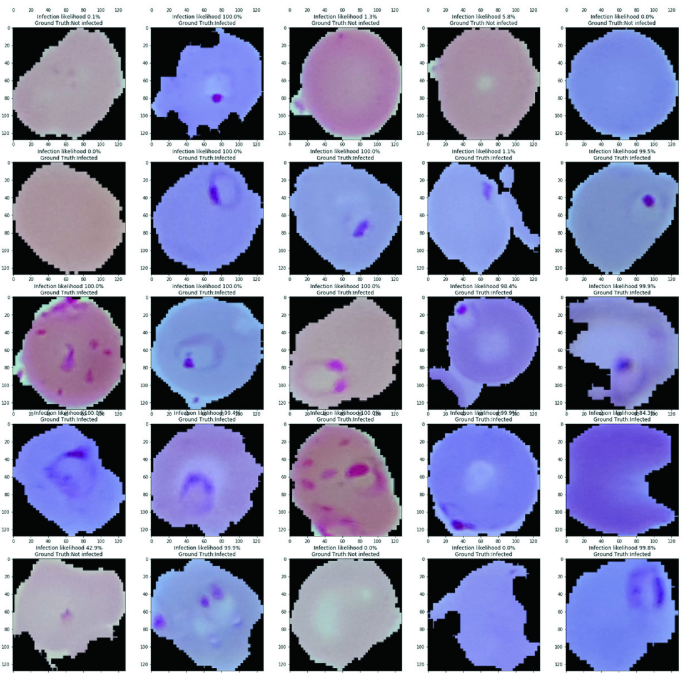

In [ ]:
!pip install --upgrade kagglehub

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")

print("Path to dataset files:", path)

100%|██████████| 675M/675M [00:08<00:00, 83.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1


In [ ]:
print(os.listdir(os.path.join(path, 'cell_images')))

['cell_images', 'Uninfected', 'Parasitized']


In [ ]:
uninfected_cells = os.path.join(path, 'cell_images', 'Uninfected')
parasitized_cells = os.path.join(path, 'cell_images', 'Parasitized')

In [ ]:
print(os.listdir(uninfected_cells))

['C101P62ThinF_IMG_20150918_151335_cell_49.png', 'C89P50ThinF_IMG_20150820_163728_cell_20.png', 'C1_thinF_IMG_20150604_104722_cell_15.png', 'C5NThinF_IMG_20150609_122006_cell_54.png', 'C98P59ThinF_IMG_20150917_153600_cell_125.png', 'C102P63ThinF_IMG_20150918_162300_cell_29.png', 'C149P110ThinF_IMG_20151115_115154_cell_30.png', 'C109P70ThinF_IMG_20150930_103811_cell_31.png', 'C153P114ThinF_IMG_20151115_135911_cell_59.png', 'C146P107ThinF_IMG_20151018_140439_cell_21.png', 'C45P6ThinF_IMG_20151130_160409_cell_62.png', 'C101P62ThinF_IMG_20150918_151006_cell_59.png', 'C164P125ThinF_IMG_20151116_113651_cell_93.png', 'C217ThinF_IMG_20151106_142147_cell_60.png', 'C225ThinF_IMG_20151112_113803_cell_77.png', 'C123P84ThinF_IMG_20151002_151851_cell_130.png', 'C6NThinF_IMG_20150609_121955_cell_155.png', 'C101P62ThinF_IMG_20150918_155731_cell_19.png', 'C112P73ThinF_IMG_20150930_131254_cell_37.png', 'C222ThinF_IMG_20151115_150057_cell_62.png', 'C37BP2_thinF_IMG_20150620_132847a_cell_7.png', 'C90P51Th

##Let's make uninfected cells 0 and infected cells 1

In [ ]:
cell_to_num = {
    0: 'Uninfected',
    1: 'Parasitized'
}

In [ ]:
print(f'Unifected Cell Images: {len(os.listdir(uninfected_cells))}')
print(f'Parasitized Cell Images: {len(os.listdir(parasitized_cells))}')

Unifected Cell Images: 13780
Parasitized Cell Images: 13780


In [ ]:
def load_image_label(image_folder, label, image_size=(64, 64)):
    images = []
    labels = []

    # Creating a list of files in directory
    file_list = os.listdir(image_folder)

    for i in tqdm(range(len(file_list)), desc="Loading Data"):
        # Index the file from the list
        filename = file_list[i]
        # print(f'Filename: {filename}')

        # Construct the full path
        file_path = os.path.join(image_folder, filename)
        # print(f'File Path: {file_path}')
        # input()

        # Turning the path into an imgage
        image = cv2.imread(file_path)


        # Skip if image couldn't be loaded
        if image is None:
            print(f"Skipping {file_path} - could not be loaded")
            continue

        # Resize the image to 64, 64
        image = cv2.resize(image, image_size)

        # Convert from BGR to RGB (OpenCV loads as BGR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Normalize pixel values to 0-1
        image = image / 255.0

        # Append to lists
        images.append(image)
        labels.append(label)

    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int32)

In [ ]:
uninfected_images, uninfected_label = load_image_label(uninfected_cells, 0)
parasitized_images, parasitized_label = load_image_label(parasitized_cells, 1)


Loading Data:  97%|█████████▋| 13374/13780 [00:11<00:00, 1234.48it/s]

Skipping /root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Uninfected/Thumbs.db - could not be loaded


Loading Data:  97%|█████████▋| 13411/13780 [00:12<00:00, 1278.30it/s]

Skipping /root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Parasitized/Thumbs.db - could not be loaded


Loading Data: 100%|██████████| 13780/13780 [00:12<00:00, 1095.93it/s]


In [ ]:
print(f'Unifected Images: {uninfected_images.shape}') # We lost an image most likely because it was bad
print(f'Unifected Labels: {uninfected_label.shape}')
print(f'Parasitized Images: {parasitized_images.shape}')
print(f'Parasitized Labels: {parasitized_label.shape}')

Unifected Images: (13779, 64, 64, 3)
Unifected Labels: (13779,)
Parasitized Images: (13779, 64, 64, 3)
Parasitized Labels: (13779,)


In [ ]:
images = np.concatenate((uninfected_images, parasitized_images), axis=0) # The images ARE NOT SUFFLED, WHEN YOU CREATE DATALOADER SHUFFLE THEM
# Right now they are all uninfected images then allparasitized (This is not good when training)
labels = np.concatenate((uninfected_label, parasitized_label), axis=0)

In [ ]:
print(images.shape)

(27558, 64, 64, 3)


#Data Visualizing

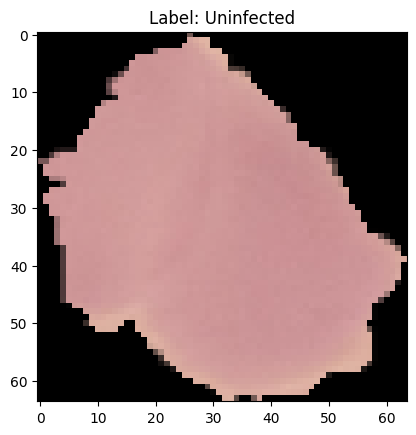

In [ ]:
image_num = 9234 #@param {type:"raw"}
plt.imshow(images[image_num])
plt.title(f'Label: {cell_to_num[labels[image_num]]}')
plt.show()

# Create the Model
> Tips:
> - Try 2-3 Conv Layers to begin with
> - Add BatchNorm, ReLU, Pooling
> - Try using Sequential API (nn.Sequential)
> - Visualize the Model

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    # CODE HERE
    super(CNN, self).__init__()

    self.conv_layers = nn.Sequential(
        # CODE HERE: add sets of Conv2d, BatchNorm2d, ReLU, and MaxPool2d; change the # of in and out channels accordingly
        nn.Conv2d(3, 16, kernel_size=3, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2, stride=2),
        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2, stride=2),
        nn.Conv2d(32, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2, stride=2),
    )

    self.fully_connected = nn.Sequential(
        # CODE HERE: add Linear layers (from wk1); change # of in and out features accordingly; add ReLU in between Linear layers
        nn.Linear(128 * 8 * 8, 128), # Corrected input features
        nn.ReLU(),
        nn.Linear(128, 2)
    )

    # CODE HERE
    self.flatten = nn.Flatten()

  def forward(self, x):
    # CODE HERE (define the forward pass using x and then return it)
    x = self.conv_layers(x)
    x = self.flatten(x)
    x = self.fully_connected(x)
    return x

# CODE HERE (initialize the model)
model = CNN()

In [ ]:
# CODE HERE (check if cuda is available otherwise use cpu, print model summary)
device = "cpu" # Explicitly set device to cpu
model.to(device)
print(device)
# model summary
summary(model, (3, 64, 64))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
       BatchNorm2d-2           [-1, 16, 64, 64]              32
              ReLU-3           [-1, 16, 64, 64]               0
         MaxPool2d-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,640
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
         MaxPool2d-8           [-1, 32, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]          36,992
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
        MaxPool2d-12            [-1, 128, 8, 8]               0
          Flatten-13                 [-1, 8192]               0
           Linear-14               

#Create the dataloaders
> Try batchsize of 32, once you've trained and have an accuracy, try 16, 8. What do you observe?

In [ ]:
# CODE HERE (print the shape of the dataset)
print(images.shape)

(27558, 64, 64, 3)


In [ ]:
# CODE HERE (convert the images into a tensor, set to variable all_images)
all_images = torch.tensor(images).permute(0, 3, 1, 2)
# permuting changes the shape from (batch, height, width, channel) into (B, C, H, W), this form is required so that the model can work with the image data

# CODE HERE (convert the labels into a tensor, set to variable all_labels)
all_labels = torch.tensor(labels).long()

In [ ]:
# CODE HERE (print the shape of the images and labels)
print(all_images.shape)
print(all_labels.shape)

torch.Size([27558, 3, 64, 64])
torch.Size([27558])


In [ ]:
# CODE HERE (declare the train_images, train_labels, test_images, test_labels)
train_images = all_images[:20000]
train_labels = all_labels[:20000]
test_images = all_images[20000:]
test_labels = all_labels[20000:]

# Recommendation: set the first 20000 samples for training and all samples after that for testing

In [ ]:
# CODE HERE (create train_set and test_set as TensorDataset using respective images and labels)
train_set = TensorDataset(train_images, train_labels)
test_set = TensorDataset(test_images, test_labels)

In [ ]:
# CODE HERE (set up the dataloaders for train and test)
train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=32, shuffle=True)

In [ ]:
# CODE HERE (set up the train_dataloader using next and iter; print shape of images and labels; print # of batches)
images, labels = next(iter(train_dataloader))
print(images.shape)
print(labels.shape)
print(len(train_dataloader))

torch.Size([32, 3, 64, 64])
torch.Size([32])
625


#Create the Loss Function & Optimizer

In [ ]:
# CODE HERE (declare loss function and optimizer)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train Loop

Recall the steps we've gone over these past 2 weeks, fill in the gaps

In [ ]:
def train_loop(train_dataloader, model, loss_fn, optimizer, epochs):
  # CODE HERE
  model.train()
  losses = []

  for epoch in range(epochs):
    train_loss_epoch = 0
    for image, label in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}"):
      # CODE HERE
      optimizer.zero_grad()
      pred = model(image)
      loss = loss_fn(pred, label)
      loss.backward()
      optimizer.step()
      train_loss_epoch += loss.item()

    # CODE HERE
    train_loss_epoch /= len(train_dataloader)
    losses.append(train_loss_epoch)
    print(f"Epoch {epoch + 1} | Loss: {train_loss_epoch}")

  return losses # CODE HERE (replace the pass with return)

In [ ]:
# CODE HERE (train the model, do at least 3 epochs)
losses = train_loop(train_dataloader, model, loss_fn, optimizer, 3)

Epoch 1: 100%|██████████| 625/625 [01:32<00:00,  6.73it/s]


Epoch 1 | Loss: 0.2562786400288343


Epoch 2: 100%|██████████| 625/625 [01:38<00:00,  6.35it/s]


Epoch 2 | Loss: 0.12880556919276714


Epoch 3: 100%|██████████| 625/625 [01:37<00:00,  6.42it/s]

Epoch 3 | Loss: 0.11056199665144086


#Visualize the Loss Drop

In [ ]:
# CODE HERE (print out the losses from training as a list)
print(losses)

[0.2562786400288343, 0.12880556919276714, 0.11056199665144086]


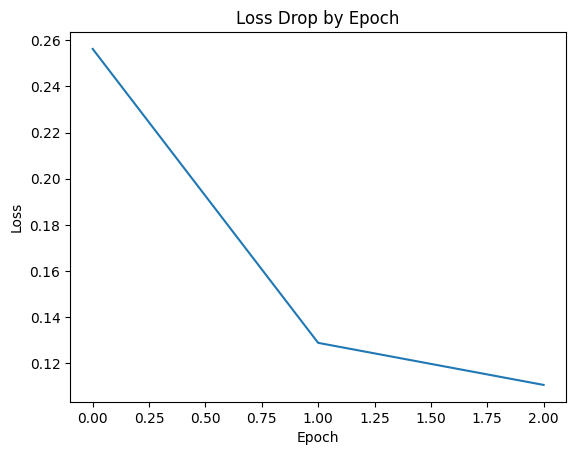

In [ ]:
# CODE HERE (use plt to graph the loss drop by epoch)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Drop by Epoch')
plt.show()

#Creating the Testing Function
> Make sure to put the model in eval mode
> Make a prediction loop
> Calculate Accuracy

In [ ]:
# CODE HERE (define accuracy function)
def accuracy(pred, label):
  return (pred.argmax(1) == label).float().mean()

Recall the steps for the test loop and fill in the blanks

In [ ]:
def test_loop(test_dataloader, model):
  # CODE HERE
  model.eval()
  losses = []
  accuracies = []

  with torch.no_grad():
    for image, label in tqdm(test_dataloader, desc="Testing Model"):
      # CODE HERE
      pred = model(image)
      loss = loss_fn(pred, label)
      acc = accuracy(pred, label)
      losses.append(loss.item())
      accuracies.append(acc.item())

    # CODE HERE (print statement)
    print(f"Loss: {np.mean(losses)} | Accuracy: {np.mean(accuracies)}")

In [ ]:
# CODE HERE (run the test loop)
test_loop(test_dataloader, model)

Testing Model: 100%|██████████| 237/237 [00:14<00:00, 16.02it/s]

Loss: 0.2542112162847559 | Accuracy: 0.9170622362869199


# Visualize a prediction with the trained model

Select an arbitrary index (or set up a random generator) and declare the `testing_image` and `testing_label`

In [ ]:
# CODE HERE (see above instructions)
testing_image, testing_label = test_set[100]

In [ ]:
# CODE HERE (set the testing_image to the device using .to(); print the shape of the testing_image)
testing_image = testing_image.to(device)
print(testing_image.shape)

torch.Size([3, 64, 64])


torch.Size([1, 2])


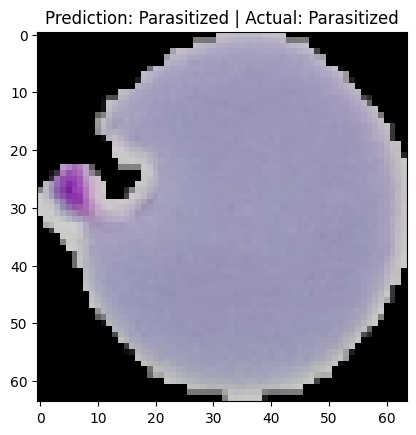

In [ ]:
with torch.no_grad():
  pred = model(testing_image.unsqueeze(0))
  print(pred.shape)

plt.imshow(testing_image.cpu().permute(1, 2, 0))
plt.title(f'Prediction: {cell_to_num[pred.argmax(1).item()]} | Actual: {cell_to_num[testing_label.item()]}')
plt.show()

# Hyperparameter Testing

- Try to go back and see how you can change some hyperparameters to get the model accuracy to be at least 80%.
- Things to ponder: # of conv-layers, # of dense layers, # of epochs, batch size, learning rate